In [10]:
import pandas as pd
import sqlite3
import os
import numpy as np
import jinja2
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain
from sspipe import p, px
import warnings
warnings.filterwarnings("ignore")

Load resturants review

In [2]:
db = sqlite3.connect('database.db')

review = pd.read_sql('SELECT * FROM resturants_review', db)

review.sample(5)

,business_id,review_id,date,stars,text,name,tokenized
328382,vUrTGX_7HxqeoQ_6QCVz6g,9NSk6Q1dPCKh7CVZhfB6_A,2021-03-01 21:20:18,5,I've only dined maybe 3 times inside this past...,Suraya,ive onli dine mayb 3 time insid thi past year ...
2362065,-0G_6-KFGpCpxTUlVXCMYQ,uydg5TKN1jn2TJd9_5j4Sw,2014-02-24 22:53:23,4,Came here to meet friends before our night out...,Gio Taco,came meet friend befor night town im glad star...
3919345,GS3YycUVd09l3AXvM3xmuA,w4Xd5AWXmp2ecGHACi7ZeA,2017-09-14 07:34:44,5,"I'm not trying to be dramatic, but you have no...",Talayna's World Class Pizza,im tri dramat live youv st loui style pizza ad...
1420432,s28vCG365GHnGkWDSSsZUA,7SerIoPXXeP1yJIXsnUZaA,2021-08-08 21:36:42,5,Went to stinger's after a 8 game Phillies win ...,Stinger’s Waterfront,went stinger 8 game philli win streak beer din...
2059717,FH0MVF7kK0D76Hh4e7hXfQ,db9KAY0kIk7HONRtoEPI1Q,2017-04-15 15:39:38,1,"Wildly expensive, meh food along with unpleasa...",Jeannine's American Bakery Restaurant,wildli expens meh food along unpleas staff fai...


In [3]:
# Sentiment is negative if the review is 1 or 2 stars, positive if 4 or 5 stars, and neutral if 3 stars.

def set_sentiment(stars):
    if stars <= 2:
        return 'negative'
    elif stars >= 4:
        return 'positive'
    else:
        return 'neutral'

review['sentiment'] = review['stars'].apply(set_sentiment)

review.head(5)

,business_id,review_id,date,stars,text,name,tokenized,sentiment
0,XQfwVwDr-v0ZS3_CbbE5Xw,KU_O5udG6zpxOg-VcAEodg,2018-07-07 22:09:11,3,"If you decide to eat here, just be aware it is...",Turning Point of North Wales,decid eat awar go take 2 hour begin end tri mu...,neutral
1,YjUWPpI6HXG530lwP-fb2A,saUsX_uimxRlCVr67Z4Jig,2014-02-05 20:30:30,3,Family diner. Had the buffet. Eclectic assortm...,Kettle Restaurant,famili diner buffet eclect assort larg chicken...,neutral
2,kxX2SOes4o-D3ZQBkiMRfA,AqPFMleE6RsU23_auESxiA,2015-01-04 00:01:03,5,"Wow! Yummy, different, delicious. Our favo...",Zaika,wow yummi differ delici favorit lamb curri kor...,positive
3,e4Vwtrqf-wpJfwesgvdgxQ,Sx8TMOWLNuJBWer-0pcmoA,2017-01-14 20:54:15,4,Cute interior and owner (?) gave us tour of up...,Melt,cute interior owner gave us tour upcom patioro...,positive
4,04UD14gamNjLY0IDYVhHJg,JrIxlS1TzJ-iCu79ul40cQ,2015-09-23 23:10:31,1,I am a long term frequent customer of this est...,Dmitri's,long term frequent custom thi establish went o...,negative


In [4]:
restaurant_chain = (pd.read_sql('SELECT name, categories FROM business', db)
                    # get the restaurant chain info
                    | px.query('categories.str.contains("Restaurants") == True')
                    
                    # get the restaurant chain name and count
                    | px.groupby('name')
                    | px.agg({'name': 'count'})
                    | px.rename(columns={'name': 'chain_count'})             
)

restaurant_summary = (review.groupby("name").agg({"text" : "count"})

                 # rename text to chain_count
                 | px.rename(columns={"text" : "review_count"})
                 
                 # join with restaurant_chain
                 | px.join(restaurant_chain, how="inner")
                 
                 # sort by chain_count
                 | px.sort_values(by="chain_count", ascending=False)
)

restaurant_summary.head(10)

,review_count,chain_count
name,,
McDonald's,18210,703
Subway,4278,459
Taco Bell,8636,365
Burger King,5510,338
Wendy's,6397,331
Wawa,4346,301
Domino's Pizza,6539,295
Pizza Hut,4780,272
Papa John's Pizza,3109,196


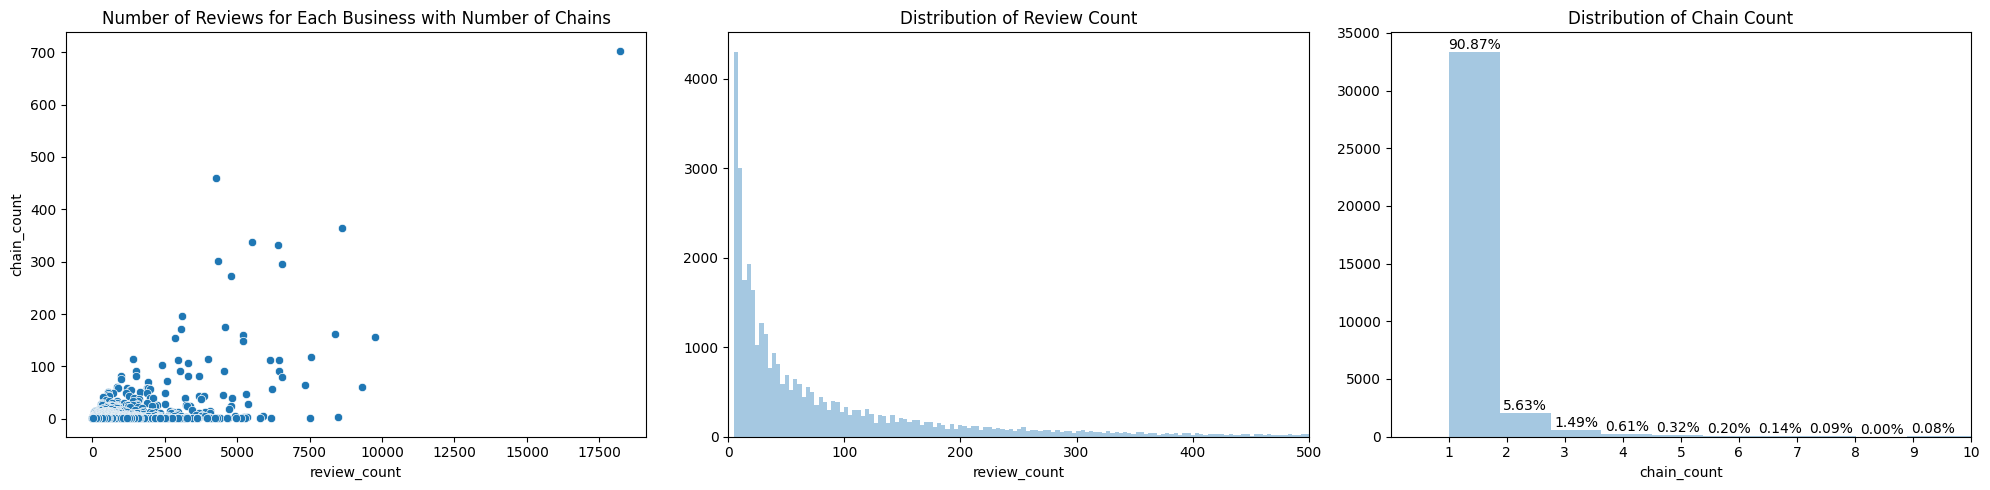

In [5]:
# create a row and three column figure
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# number of reviews for each business with number of chains
sns.scatterplot(x="review_count", y="chain_count", data=restaurant_summary, ax=ax[0])

# distribution of review count and set x from 0 to 500
sns.distplot(restaurant_summary["review_count"], ax=ax[1], kde=False, bins=5000)
ax[1].set_xlim(0, 500)

# distribution of chain count and set x from 0 to 10
sns.distplot(restaurant_summary["chain_count"], ax=ax[2], kde=False, bins=800)
ax[2].set_xlim(0, 10)

# show ones over 10 chains in last bin
ax[2].set_xticks(range(1, 11))

# show value of each bin over bin as percentage
for p in ax[2].patches:
    ax[2].annotate("{:.2f}%".format(p.get_height() / len(restaurant_summary) * 100), 
    (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# titles for each plot
ax[0].set_title("Number of Reviews for Each Business with Number of Chains")
ax[1].set_title("Distribution of Review Count")
ax[2].set_title("Distribution of Chain Count")

plt.tight_layout()
plt.show()

In [6]:
# use itertools to count all the words in the text_cleaned column
word_counts = Counter(chain.from_iterable(review['tokenized'].str.split(' ')))

# ignore the words that are less than 5 times in the text_cleaned column
word_counts = {k:v for k,v in word_counts.items() if v > 5}

# convert the word_counts dict to a dataframe and sort it by the count
word_count_summary = ( pd.DataFrame.from_dict(word_counts, orient='index').reset_index()
                     | px.rename(columns={'index': 'word', 0: 'count'}) 
                     | px.sort_values(by='count', ascending=False) 
                     | px.reset_index(drop=True)    
                     | px.assign(rank=lambda df: df.index + 1)
                     | px[['rank', 'word', 'count']]
)

In [7]:
show_table_template = """
<div class="row">
    {% for table in tables %}
        <div class="column" style = "float: left; margin-left:30px"> {{ table }} </div>
    {% endfor %}
  </div>
"""

# show top 40 words with highest count display in tables of 
row_count = 10
word_list = [word_count_summary[i:i+row_count].to_html(index=False) for i in range(0, 40, row_count)]
html_code = jinja2.Template(show_table_template).render(tables=word_list)

HTML(html_code)

rank,word,count
1,wa,9599263
2,thi,3796414
3,food,3461717
4,good,2765909
5,place,2697974
6,order,2339421
7,great,2197148
8,veri,1937831
9,time,1788490
10,like,1691041


name,Burger King,McDonald's,Subway,Taco Bell,Wendy's
serial_date,,,,,
2021-09,1.6,1.5,1.9,1.7,1.7
2021-10,1.6,1.5,2.0,1.6,1.8
2021-11,1.7,1.5,2.0,1.7,1.8
2021-12,1.7,1.5,2.1,1.7,1.8
2022-01,1.8,1.6,2.3,1.8,1.7


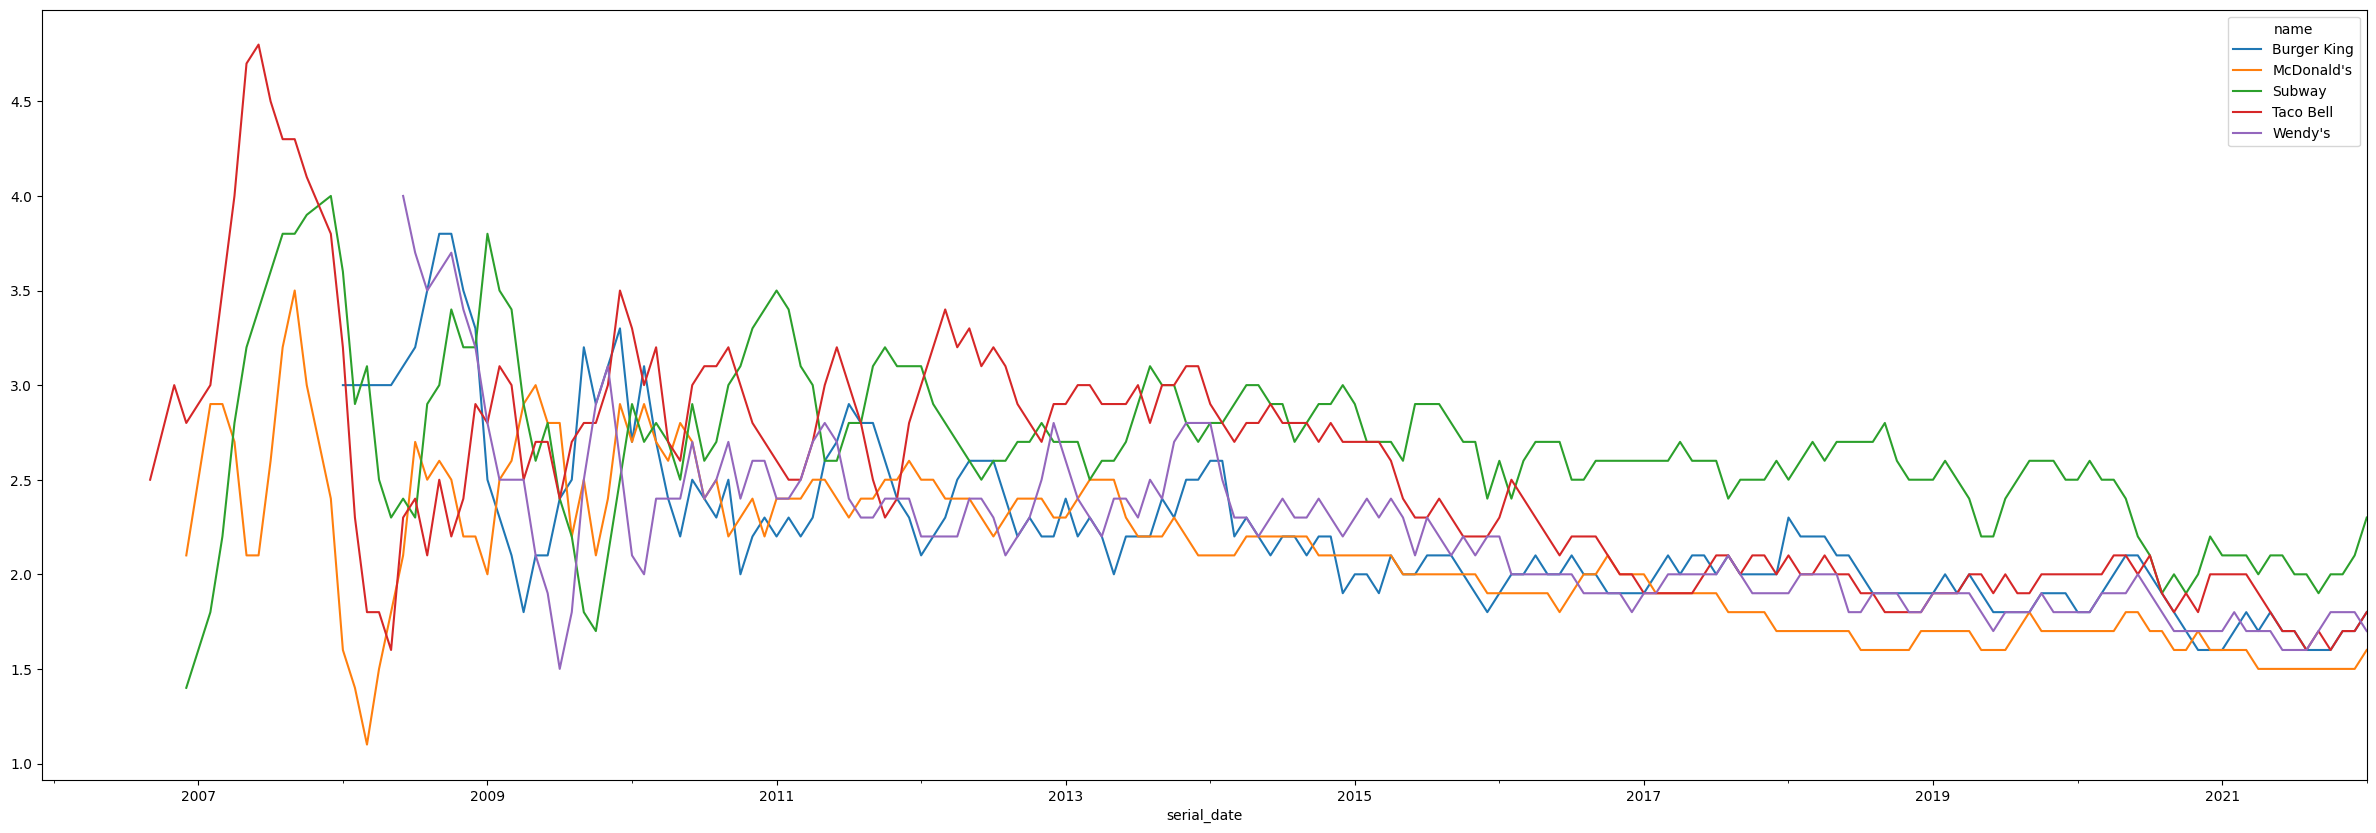

In [8]:
# get top 5 by chain_count restaurant_summary

top_restaurant_data = (review[review['name'].isin(restaurant_summary[:5].index) ]
                       | px.assign(serial_date=lambda df: pd.to_datetime(df['date']).dt.to_period('M'))
                       | px.groupby(['serial_date', 'name'])['stars'].mean().unstack()
                       | px.interpolate()
                       | px.rolling(4).mean()
                       | px.round(1)
)

display(top_restaurant_data.tail(5))
top_restaurant_data.plot(figsize=(30, 10))
plt.show()

In [11]:
# query Chipotle Mexican Grill reviews that tokenized contains any of the word in word_list
food_related_sickness = ['sick','fever', 'ach', 'vomit', 'poison', 'contamin', 'choke']

def filter_using_specific_word(business_name, review, word_list):
    check_if_it_has = lambda sentense, word_list: np.any(np.isin(word_list, sentense.split(' ')))

    df = review.query('name == "%s"' % business_name)
    df['has_food_sickness'] = df['tokenized'].apply(check_if_it_has, word_list=word_list)
    df.query('has_food_sickness == True', inplace=True)
    return df
    

chipotle_sick = filter_using_specific_word('Chipotle Mexican Grill', review, food_related_sickness)

negative_food_related_sickness = len(chipotle_sick.query('sentiment == "negative"'))

print(f"Chipotle Mexican Grill has %d reviews that contain sick related reviews and %d (%s) of them are negative reviews."  
    % (len(chipotle_sick), negative_food_related_sickness, f'{negative_food_related_sickness / len(chipotle_sick):0.1%}'))
    

chipotle_sick.sample(5)

Chipotle Mexican Grill has 265 reviews that contain sick related reviews and 222 (83.8%) of them are negative reviews.


,business_id,review_id,date,stars,text,name,tokenized,sentiment,has_food_sickness
1654189,4rhH2r1lL7ujqnvTwZo--w,Jg2qJVJxw6yqhee7U-rxrg,2019-08-28 11:40:10,1,I got violent food poisoning after I ate here ...,Chipotle Mexican Grill,got violent food poison ate last friday want g...,negative,True
1465954,jxouzim2QaotZa3DYZLweg,mnv0uzB8134K0CN63r6wuw,2015-12-07 02:27:29,1,I would do negative stars if I could. My husba...,Chipotle Mexican Grill,would neg star could husband brother law ate t...,negative,True
2560420,tnq7b6ROl4RIyfQoxIrXhw,xIRcNWmoKGB1ZHoIpugABQ,2017-04-07 00:59:57,2,This Chipotle is weak. Employees aren't consid...,Chipotle Mexican Grill,thi chipotl weak employe arent consider dish t...,negative,True
3534183,bMMf5bjTAT8LrwhE84ZuNw,EzkvYxwDCri36cmAB8RL5w,2011-04-02 01:39:54,1,AWFUL!!!!!! Came in today with my bf we just c...,Chipotle Mexican Grill,aw came today bf came philli game 13 burrito d...,negative,True
2660724,44klPO-2HedNmQc-LMg5jQ,VYMyzMjckrpLTnAGZNsZHQ,2015-12-04 09:30:07,1,2 of my friends just recently succumbed to foo...,Chipotle Mexican Grill,2 friend recent succumb food poison thi locat ...,negative,True


In [30]:
word_count_df = chipotle_sick.query('sentiment == "negative"').copy()
word_count_df['serial_date'] = pd.to_datetime(word_count_df['date']).apply(lambda x: x.strftime('%Y-%U'))

for word in food_related_sickness:
    word_count_df[word] = word_count_df['tokenized'].str.contains(word).astype(int)

word_count_df = word_count_df[['serial_date'] + food_related_sickness]
word_count_df = word_count_df.groupby('serial_date').sum()
word_count_df.sample(5)

,sick,fever,ach,vomit,poison,contamin,choke
serial_date,,,,,,,
2018-03,1,0,1,1,1,0,0
2021-44,2,0,0,0,0,0,0
2018-17,1,0,1,0,0,0,0
2018-19,0,0,0,0,0,1,0
2019-52,1,0,0,0,0,0,0


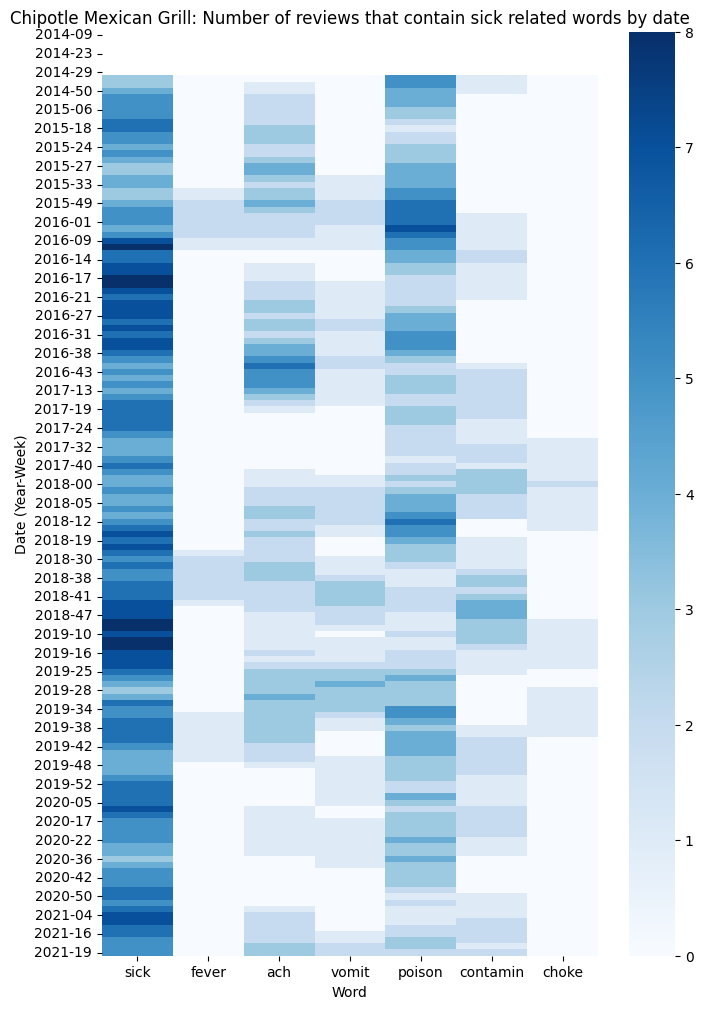

In [31]:
# drop if index is smaller that 2014-01
word_count_df = (word_count_df
                | px.query('serial_date >= "2014-01"')
                | px.query('serial_date < "2021-20"')
)

# create heatmap date as x asix and each word in food_related_sickness as y axis

plt.figure(figsize=(8, 12))

# smooth the line
word_count_df = word_count_df.rolling(8).sum()

sns.heatmap(word_count_df, cmap='Blues')
plt.title('Chipotle Mexican Grill: Number of reviews that contain sick related words by date')
plt.xlabel('Word')
plt.ylabel('Date (Year-Week)')
plt.show()